# Анализ рынка заведений общественного питания Москвы

**Задача:** провести исследование рынка общественного питания Москвы.

**Цель:**
- изучить основные особенности рынка заведений общественного питания Москвы;
- сформировать рекомендации для заказчика по открытию кофейни (в т.ч. определить тип заведения, потенциальное расположение и ценовую политику).

**Ход исследования:**

Анализ проводится на основе данных сервисов Яндекс Карты и Яндекс Бизнес на лето 2022 года (в данных присутствует информация, добавленная пользователями или найдена в общедоступных источниках).

1. Изучить датасет
2. Предобработка.
    - информация добавляется пользователями, поэтому сначала необходимо провести предобработку данных (проверить наличие ошибок, пропусков и дубликатов).
2. Изучение особенностей рынка общепита:
    - определить наиболее популярные категории заведений;
    - рассмотреть соотношение сетевых и несетевых заведений, определить наиболее распространенные сети общепита (топ-15);
    - изучить расположение заведений (в разбивке по категориям) по районам Москвы;
    - проанализировать средний рейтинг заведений;
    - изучить средние чеки по районам;
3. Провести аналогичные исследования по кофейням Москвы.

## Изучение датасета

In [1]:
!pip install folium

In [82]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from folium import Map, Marker, Choropleth
from folium.plugins import MarkerCluster
import json

In [3]:
df = pd.read_csv('/datasets/moscow_places.csv')

Изучим датасет:

In [4]:
df.head()

name  category                              address  \
0                WoWфли      кафе           Москва, улица Дыбенко, 7/1   
1        Четыре комнаты  ресторан   Москва, улица Дыбенко, 36, корп. 1   
2                 Хазри      кафе       Москва, Клязьминская улица, 15   
3  Dormouse Coffee Shop   кофейня  Москва, улица Маршала Федоренко, 12   
4             Иль Марко  пиццерия      Москва, Правобережная улица, 1Б   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   
3  Северный административный округ   
4  Северный административный округ   

                                               hours        lat        lng  \
0                             ежедневно, 10:00–22:00  55.878494  37.478860   
1                             ежедневно, 10:00–22:00  55.875801  37.484479   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...  55.889146  37.525901   
3                             ежедневно, 09:00–22:00  55.881608  37.488860   
4                             ежедневно, 10:00–22:00  55.881166  37.449357   

   rating          price                       avg_bill  middle_avg_bill  \
0     5.0            NaN                            NaN              NaN   
1     4.5  выше среднего       Средний счёт:1500–1600 ₽           1550.0   
2     4.6        средние         Средний счёт:от 1000 ₽           1000.0   
3     5.0            NaN  Цена чашки капучино:155–185 ₽              NaN   
4     5.0        средние         Средний счёт:400–600 ₽            500.0   

   middle_coffee_cup  chain  seats  
0                NaN      0    NaN  
1                NaN      0    4.0  
2                NaN      0   45.0  
3              170.0      0    NaN  
4                NaN      1  148.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


Всего в датасете 8406 строк. Из 14 столбцов пропуски в данных имеются в 6 столбцах, при чем почти во всех столбцах (кроме hours) количество пропусков значимое - более 50%. В основном пропуски встречаются в столбцах с ценами, восстановить эти данные невозможно, но можно попробовать поискать значения в одном из столбцов, которые позволят восстановить данные в другом.

Данные с кол-вом посадочных мест восстановить не возможно.

Тип данных в столбце chain - целочисленный, содержит значения 1 либо 0. В остальных столбцах данные либо текстовые (тип object), либо вещественные числа (тип float).

Для удобства дальнейшего анализа заполним пропуски в столбце с часами работы значением "неизвестно". Восстановить такие данные без больших трудозатрат не представляется возможным, а добавленное значение не исказит имеющиеся данные.

In [6]:
df['hours'] = df['hours'].fillna('неизвестно')

In [7]:
df['name'] = df['name'].str.lower()

In [8]:
print(f'В датасете представлено', df['name'].nunique(), 'заведений')

В датасете представлено 5512 заведений


In [9]:
df.describe().T

count        mean          std        min         25%  \
lat                8406.0   55.750109     0.069658  55.573942   55.705155   
lng                8406.0   37.608570     0.098597  37.355651   37.538583   
rating             8406.0    4.229895     0.470348   1.000000    4.100000   
middle_avg_bill    3149.0  958.053668  1009.732845   0.000000  375.000000   
middle_coffee_cup   535.0  174.721495    88.951103  60.000000  124.500000   
chain              8406.0    0.381275     0.485729   0.000000    0.000000   
seats              4795.0  108.421689   122.833396   0.000000   40.000000   

                          50%          75%           max  
lat                 55.753425    55.795041     55.928943  
lng                 37.605246    37.664792     37.874466  
rating               4.300000     4.400000      5.000000  
middle_avg_bill    750.000000  1250.000000  35000.000000  
middle_coffee_cup  169.000000   225.000000   1568.000000  
chain                0.000000     1.000000      1.000000  
seats               75.000000   140.000000   1288.000000

Минимальное значение в столбцах со средним счетом и кол-вом посадочных мест выглядит странно, в остальных столбцах с минимальными значениями проблем нет. Значения рейтинга корректны. Широта и долгота (55 и 37) совпадают с Московской, дополнительно можно проверить, что в датасете данные только по г. Москва (т.е. проверить, что в столбце адрес первый элемент это Москва).

In [10]:
df['address'].apply(lambda x: re.split(pattern=', ', string=x)[0]).unique()

array(['Москва'], dtype=object)

В столбцах со средним счетом, средней ценой чашки кофе и кол-вом посадочных места можно увидеть аномальные выбросы - изучим значения в этих столбцах подробнее.

Посмотрим как распределены значения в столбце со средним счетом.

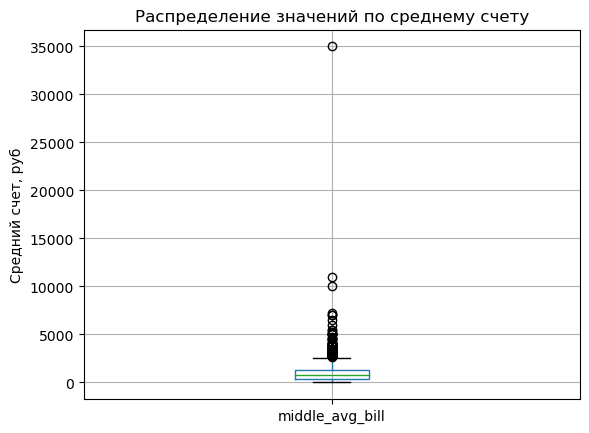

In [11]:
df.boxplot(column='middle_avg_bill')
plt.ylabel('Средний счет, руб')
plt.title('Распределение значений по среднему счету');

In [12]:
df.query('middle_avg_bill >= 10000')

name  category                              address  \
730   чойхона   бар,паб       Москва, Дмитровское шоссе, 95А   
5481    гости  ресторан        Москва, шоссе Энтузиастов, 52   
7177     кафе  ресторан  Москва, Каширское шоссе, 23, стр. 2   

                              district                     hours        lat  \
730    Северный административный округ    ежедневно, 10:00–23:00  55.871497   
5481  Восточный административный округ         пн,вс 18:00–22:30  55.759088   
7177      Южный административный округ  ежедневно, круглосуточно  55.657450   

            lng  rating    price                    avg_bill  middle_avg_bill  \
730   37.543555     4.4  высокие   Средний счёт:5000–17000 ₽          11000.0   
5481  37.760570     4.1  высокие   Средний счёт:5000–15000 ₽          10000.0   
7177  37.646665     4.1  высокие  Средний счёт:20000–50000 ₽          35000.0   

      middle_coffee_cup  chain  seats  
730                 NaN      0   49.0  
5481                NaN      0    NaN  
7177                NaN      0  100.0

Судя по названиям и расположению мест (кроме ресторана Гости) в среднем ценнике явно ошибка, возможно корректное значение можно получить разделив на 10 или 100, но т.к. данные по категории, рейтингу и кол-ву посадочных мест выглядят сомнительно, то просто удалим эти строки.

In [13]:
df = df.drop([730, 7177]).reset_index(drop=True)

In [14]:
df.query('middle_avg_bill == 0')

name category                        address  \
3687  кофемания  кофейня  Москва, улица Новый Арбат, 19   

                                district                     hours        lat  \
3687  Центральный административный округ  ежедневно, круглосуточно  55.752136   

            lng  rating    price             avg_bill  middle_avg_bill  \
3687  37.587784     4.5  высокие  Средний счёт:от 0 ₽              0.0   

      middle_coffee_cup  chain  seats  
3687                NaN      1  200.0

Значение среднего счета похоже на ошибку. Т.к. это сетевое заведение, можно заполнить данные наиболее частым значением для этой сети.

In [15]:
df.loc[3687, 'avg_bill'] = df.query('name == "кофемания"')['avg_bill'].mode()[0]
df.loc[3687, 'middle_avg_bill'] = df.query('name == "кофемания"')['middle_avg_bill'].mode()[0]

Также заполним пропуски в среднем чеке других заведений этой сети

In [16]:
df.loc[df['name'] == 'кофемания', 'avg_bill'] = df.loc[df['name'] == 'кофемания', 'avg_bill'] \
                                            .fillna(df.query('name == "кофемания"')['avg_bill'].mode()[0])
df.loc[df['name'] == 'кофемания', 'middle_avg_bill'] = df.loc[df['name'] == 'кофемания', 'middle_avg_bill'] \
                                                .fillna(df.query('name == "кофемания"')['middle_avg_bill'].mode()[0])

Теперь изучим значения в столбце со средней ценой чашки кофе:

In [17]:
df.boxplot(column='middle_coffee_cup')
plt.title('Распределение значений средней цены чашки кофе')
plt.ylabel('Средняя цена чашки кофе, руб');

In [18]:
df[df['middle_coffee_cup'] > 1000]

name category                                         address  \
2858  шоколадница  кофейня  Москва, Большая Семёновская улица, 27, корп. 1   

                              district                   hours        lat  \
2858  Восточный административный округ  ежедневно, 08:00–23:00  55.782268   

            lng  rating    price                        avg_bill  \
2858  37.709022     4.2  средние  Цена чашки капучино:230–2907 ₽   

      middle_avg_bill  middle_coffee_cup  chain  seats  
2858              NaN             1568.0      1   48.0

Тут явно опечатка, цена чашки от 230 до 290 руб, исправим это вручную.

In [19]:
df.loc[2858, 'avg_bill'] = 'Цена чашки капучино:230-290 ₽'
df.loc[2858, 'middle_coffee_cup'] = (230+290)/2

Теперь посмотрим значения по кол-ву посадочных мест.

In [20]:
len(df.query('seats == 0'))

136

In [21]:
df.query('seats == 0')

name         category  \
84              meat doner kebab         булочная   
177                       арамье         булочная   
196                 донер-шашлык         ресторан   
203                   тандыр № 1             кафе   
211             неаполитан пицца             кафе   
...                          ...              ...   
8116                        бико         булочная   
8166            чайхана уч кудук          кофейня   
8170                  масса кофе          кофейня   
8334  сочная шаурма в кузьминках  быстрое питание   
8360                      достор             кафе   

                                          address  \
84                      Москва, улица Лескова, 22   
177   Москва, улица 800-летия Москвы, 22, корп. 2   
196                     Москва, улица Лескова, 22   
203                    Москва, улица Лескова, 22Г   
211                    Москва, улица Пришвина, 23   
...                                           ...   
8116    Москва, улица Симоновский Вал, 13, стр. 3   
8166   Москва, улица Симоновский Вал, 26, корп. 1   
8170              Москва, Холодильный переулок, 2   
8334          Москва, Волгоградский проспект, 102   
8360               Москва, Вешняковская улица, 43   

                                     district  \
84    Северо-Восточный административный округ   
177           Северный административный округ   
196   Северо-Восточный административный округ   
203   Северо-Восточный административный округ   
211   Северо-Восточный административный округ   
...                                       ...   
8116     Юго-Восточный административный округ   
8166             Южный административный округ   
8170             Южный административный округ   
8334     Юго-Восточный административный округ   
8360         Восточный административный округ   

                                     hours        lat        lng  rating  \
84                ежедневно, круглосуточно  55.896987  37.608126     4.5   
177                 ежедневно, 09:00–21:00  55.879392  37.556832     4.0   
196               ежедневно, круглосуточно  55.896962  37.608300     4.5   
203               ежедневно, круглосуточно  55.895615  37.611049     4.0   
211                 ежедневно, 12:00–23:00  55.885416  37.604650     4.3   
...                                    ...        ...        ...     ...   
8116                ежедневно, 08:00–20:00  55.723340  37.664252     1.3   
8166                ежедневно, 09:00–00:00  55.718663  37.662887     4.3   
8170  пн-пт 08:00–20:00; сб,вс 09:00–20:00  55.709713  37.624388     4.3   
8334              ежедневно, круглосуточно  55.703834  37.773831     3.9   
8360                ежедневно, 09:00–00:00  55.716153  37.821948     4.1   

        price                       avg_bill  middle_avg_bill  \
84        NaN             Средний счёт:300 ₽            300.0   
177       NaN                            NaN              NaN   
196       NaN                            NaN              NaN   
203       NaN                            NaN              NaN   
211       NaN                            NaN              NaN   
...       ...                            ...              ...   
8116      NaN                            NaN              NaN   
8166      NaN                            NaN              NaN   
8170  средние  Цена чашки капучино:100–210 ₽              NaN   
8334      NaN         Средний счёт:120–130 ₽            125.0   
8360  средние         Средний счёт:300–800 ₽            550.0   

      middle_coffee_cup  chain  seats  
84                  NaN      0    0.0  
177                 NaN      1    0.0  
196                 NaN      0    0.0  
203                 NaN      1    0.0  
211                 NaN      0    0.0  
...                 ...    ...    ...  
8116                NaN      0    0.0  
8166                NaN      0    0.0  
8170              155.0      0    0.0  
8334                NaN      0    0.0  
8360                NaN      0 

Таких заведений немного (около 2%), скорее всего это заведения с едой/кофе на вынос, либо фудкорт. Не будем считать это значение ошибкой. 

In [22]:
df.boxplot(column='seats')
plt.title('Распределение значений по кол-ву посадочных мест')
plt.ylabel('Кол-во мест в заведении');

In [23]:
df.query('seats > 700')

name         category  \
2712         ваня и гоги          бар,паб   
2721           маргарита  быстрое питание   
2769         шоколадница          кофейня   
2965            матрешка             кафе   
4179              eataly          бар,паб   
4230  рестобар argomento         столовая   
4244      стейк & бургер             кафе   
5485                 дом             кафе   
6517         delonixcafe         ресторан   
6523           ян примус         ресторан   
6573              мюнгер         пиццерия   
6640    one price coffee          кофейня   
6657              гудбар          бар,паб   
6683     пивной ресторан          бар,паб   
6689      японская кухня         ресторан   
6770               точка             кафе   
6806  loft-cafe академия             кафе   
6807        яндекс лавка         ресторан   
6837  alternative coffee          кофейня   

                                         address  \
2712     Москва, Измайловское шоссе, 71, корп. А   
2721     Москва, Измайловское шоссе, 71, корп. А   
2769     Москва, Измайловское шоссе, 71, корп. А   
2965     Москва, Измайловское шоссе, 71, корп. А   
4179                   Москва, Киевская улица, 2   
4230    Москва, Кутузовский проспект, 41, стр. 1   
4244                   Москва, Киевская улица, 2   
5485                     Москва, улица Юности, 1   
6517   Москва, проспект Вернадского, 94, корп. 1   
6523  Москва, проспект Вернадского, 121, корп. 1   
6573   Москва, проспект Вернадского, 97, корп. 1   
6640    Москва, проспект Вернадского, 84, стр. 1   
6657   Москва, проспект Вернадского, 97, корп. 1   
6683  Москва, проспект Вернадского, 121, корп. 1   
6689  Москва, проспект Вернадского, 121, корп. 1   
6770    Москва, проспект Вернадского, 84, стр. 1   
6806    Москва, проспект Вернадского, 84, стр. 1   
6807    Москва, проспект Вернадского, 51, стр. 1   
6837    Москва, проспект Вернадского, 41, стр. 1   

                              district  \
2712  Восточный административный округ   
2721  Восточный административный округ   
2769  Восточный административный округ   
2965  Восточный административный округ   
4179   Западный административный округ   
4230   Западный административный округ   
4244   Западный административный округ   
5485  Восточный административный округ   
6517   Западный административный округ   
6523   Западный административный округ   
6573   Западный административный округ   
6640   Западный административный округ   
6657   Западный административный округ   
6683   Западный административный округ   
6689   Западный административный округ   
6770   Западный административный округ   
6806   Западный административный округ   
6807   Западный административный округ   
6837   Западный административный округ   

                                                  hours        lat        lng  \
2712                             ежедневно, 11:00–06:00  55.789842  37.750282   
2721                             ежедневно, 10:00–22:00  55.789527  37.752004   
2769  пн-ср 11:00–23:00; чт 11:00–00:00; пт,сб 11:00...  55.789903  37.749822   
2965                                         неизвестно  55.789867  37.749656   
4179                             ежедневно, 12:00–23:00  55.743405  37.562535   
4230                             ежедневно, 12:00–23:00  55.738237  37.531819   
4244                             ежедневно, 09:00–21:00  55.742953  37.561872   
5485                                         неизвестно  55.736204  37.815500   
6517                           ежедневно, круглосуточно  55.652577  37.475730   
6523  пн-чт 12:00–00:00; пт,сб 12:00–02:00; вс 12:00...  55.657166  37.481519   
6573               пн-пт 08:00–21:00; сб,вс 10:00–21:00  55.667505  37.491001   
6640                             ежедневно, 08:30–20:00  55.665129  37.478635   
6657               пн-пт 11:00–23:00; сб,вс 13:00–23:00  55.667327  37.490601   
6683                                         неизвестно  55.657133  37.481508   
6689                  

Можно заметить, что аномально большое кол-во посадочных мест встречается у заведений, расположенных на одной улице или даже по одному адресу. Можно было бы сделать предположение, что эти кафе расположены в формате "фудкорт", но, например, шоколадница как правило имеет свой отдельный зал. Более 700 посадочных мест может быть только у больших площадкок (для банкета, например), поэтому будем считать, что в данных опечатка и все значения больше 700 необходимо разделить на 10.

In [24]:
df.loc[df['seats'] > 700, ['seats']] = round(df.loc[df['seats'] > 700, ['seats']]/10)

Посмотрим можно ли восстановить какие-либо данные в столбцах с ценами.

In [25]:
df['avg_bill'].str.contains("Цена чашки")

0         NaN
1       False
2       False
3        True
4       False
        ...  
8399      NaN
8400      NaN
8401    False
8402      NaN
8403      NaN
Name: avg_bill, Length: 8404, dtype: object

In [26]:
len(df[(df['avg_bill'] != "NaN") & (df['avg_bill'].str.contains("Цена чашки")) & (df['middle_coffee_cup'] == "NaN")])

0

In [27]:
len(df[(df['avg_bill'] != "NaN") & (df['avg_bill'].str.contains("Средний")) & (df['middle_avg_bill'] == "NaN")])

0

В ценовых столбцах нет данных, которые бы позволили заполнить столбцы со средними ценами.

Посмотрим как распределены значения среднего чека по категориям цен в заведениях

In [28]:
sns.stripplot(x='price', y='middle_avg_bill', data=df)
plt.grid()
plt.ylim(0, 5000)
plt.ylabel('Средний счет, руб')
plt.xlabel('Ценовая категория заведения')
plt.title('Средний чек заведений по ценовым категориям');

Диапазоны ценовых категорий строго не заданы, поэтому есть области пересечения, а также ошибки в соотнесении среднего чека и ценовой категории заведения. Можно рекомендовать доработать форму заоплнения данных о заведении таким образом, чтобы ценовая категория определялась автоматически на основе оценки среднего чека.

В целом можно перезадать категории, но данные не будут исследоваться в таком разрезе, поэтому пока оставим как есть.

## Предобработка

*Изучите, есть ли дубликаты в данных. Поищите пропуски: встречаются ли они, в каких столбцах? Можно ли их обработать или оставить как есть?
Выполните предобработку данных: Создайте столбец street с названиями улиц из столбца с адресом. Создайте столбец is_24/7 с обозначением, что заведение работает ежедневно и круглосуточно (24/7).*

In [29]:
df.duplicated().sum()

0

In [30]:
df.duplicated(subset=['name', 'address']).sum()

3

In [31]:
df[df.duplicated(subset=['name', 'address'], keep=False)]

name  category  \
1429                  more poke  ресторан   
1510                  more poke  ресторан   
2210  раковарня клешни и хвосты  ресторан   
2419  раковарня клешни и хвосты   бар,паб   
3090            хлеб да выпечка  булочная   
3108            хлеб да выпечка      кафе   

                                      address  \
1429  Москва, Волоколамское шоссе, 11, стр. 2   
1510  Москва, Волоколамское шоссе, 11, стр. 2   
2210               Москва, проспект Мира, 118   
2419               Москва, проспект Мира, 118   
3090              Москва, Ярцевская улица, 19   
3108              Москва, Ярцевская улица, 19   

                                     district  \
1429          Северный административный округ   
1510          Северный административный округ   
2210  Северо-Восточный административный округ   
2419  Северо-Восточный административный округ   
3090          Западный административный округ   
3108          Западный административный округ   

                                                  hours        lat        lng  \
1429                             ежедневно, 09:00–21:00  55.806307  37.497566   
1510  пн-чт 09:00–18:00; пт,сб 09:00–21:00; вс 09:00...  55.806307  37.497566   
2210                             ежедневно, 12:00–00:00  55.810553  37.638161   
2419  пн-чт 12:00–00:00; пт,сб 12:00–01:00; вс 12:00...  55.810677  37.638379   
3090                             ежедневно, 09:00–22:00  55.738886  37.411648   
3108                                         неизвестно  55.738449  37.410937   

      rating price avg_bill  middle_avg_bill  middle_coffee_cup  chain  seats  
1429     4.2   NaN      NaN              NaN                NaN      0  188.0  
1510     4.2   NaN      NaN              NaN                NaN      1  188.0  
2210     4.4   NaN      NaN              NaN                NaN      0  150.0  
2419     4.4   NaN      NaN              NaN                NaN      1  150.0  
3090     4.1   NaN      NaN              NaN                NaN      1  276.0  
3108     4.1   NaN      NaN              NaN                NaN      0  276.0

In [32]:
df = df.drop([1429, 2210, 3108]).reset_index(drop=True)

In [33]:
df[df.duplicated(subset=['address', 'lat', 'lng'], keep=False)].sort_values(by='address')

name         category  \
1070                                 кафе  быстрое питание   
1073                  халяль кафе-пекарня         булочная   
7762                          за обе щёки             кафе   
7655                            100лоффка         столовая   
348                              meat лав         ресторан   
662                     family cafe mayak         ресторан   
121                               встреча             кафе   
182                               карелия             кафе   
2998                           хинкальная             кафе   
2936                        прошу к столу         булочная   
1790                бансонс бургер китчен         ресторан   
2005                        лепим и варим             кафе   
7782                               тануки         ресторан   
7776                                  ёрш         пиццерия   
6107                            союз кофе         пиццерия   
6077                          белая птица         пиццерия   
3516                                  ava         ресторан   
3755                              patriki         ресторан   
6346                      любовь пирогова         булочная   
8081       кулинарная школа ginza project             кафе   
7635                      крошка картошка  быстрое питание   
7633                             кофешефф         ресторан   
7072                           южная ночь  быстрое питание   
7062                                 кофе             кафе   
8396                           суши мания             кафе   
271                                 алали  быстрое питание   
273                              pho oanh             кафе   
2971                           позы&буузы             кафе   
2948                      georgian garden             кафе   
2863                  dragon mixology bar             кафе   
2716                    dragon bubble tea             кафе   
4282                   пловная-чебуречная  быстрое питание   
4238                пельменная-вареничная  быстрое питание   
6530                 fibo pasta & ravioli             кафе   
6545                                 bổ             кафе   
6594                              узбечка         столовая   
6805                          кафе восток             кафе   
6222                       laserland кафе             кафе   
6083                     франклинс бургер         ресторан   
6093                          креветочная  быстрое питание   
6295                            городское             кафе   
8014                           пицца кофе         пиццерия   
4421                     soul in the bowl             кафе   
4384                       стейк & бургер         ресторан   
6798                   кравченко 8 стр. 6             кафе   
6772                           папа джонс         пиццерия   
1450                            сикварули         ресторан   
1323             кафе-кулинария сикварули         ресторан   
6384                                prime         ресторан   
8090                              белочка         ресторан   
5312                                 леон         ресторан   
5310                                 leon         ресторан   
7357                           хинкальная             кафе   
7402                        старый дворик             кафе   
4052                        steak it easy         ресторан   
3711                           чайхона №1         ресторан   
6179                               даблби          кофейня   
6138  кулинарная лавка братьев караваевых             кафе   

                                     address  \
1070   Москва, Анадырский проезд, 8, корп. 1   
1073   Москва, Анадырский проезд, 8, корп. 1   
7762       Москва, Варшавское шоссе, вл132/2   
7655       Москва, Варшавское шоссе, вл132/2   
348           Москва, Головинское шоссе, 10Б   
662           Москва, Головинское шоссе, 10Б   
121           Москва, Карельский бульвар, 

Есть неявные дубли - сикварули, а также leon/леон. Для первого случая оставим строку, где название указано без категории заведения, а во втором, посмотрим какое написание в датасете встречается чаще.

In [34]:
df.query('name == "leon" or name == "леон"')

name  category                              address  \
1052  leon  ресторан  Москва, проспект Мира, 119, стр. 10   
5310  leon  ресторан       Москва, улица Металлургов, 29А   
5312  леон  ресторан       Москва, улица Металлургов, 29А   

                                     district  \
1052  Северо-Восточный административный округ   
5310         Восточный административный округ   
5312         Восточный административный округ   

                                     hours        lat        lng  rating  \
1052  вт-пт 12:00–20:00; сб,вс 12:00–22:00  55.829632  37.629695     4.0   
5310     пн-сб 11:00–23:00; вс 12:00–23:00  55.759603  37.791702     4.3   
5312     пн-сб 11:00–23:00; вс 12:00–23:00  55.759603  37.791702     4.4   

     price avg_bill  middle_avg_bill  middle_coffee_cup  chain  seats  
1052   NaN      NaN              NaN                NaN      1    NaN  
5310   NaN      NaN              NaN                NaN      1    NaN  
5312   NaN      NaN              NaN                NaN      0    NaN

In [35]:
df = df.drop([1323, 5312]).reset_index(drop=True)

In [36]:
df.loc[df['name'] == 'яндекс.лавка', 'name'] = 'яндекс лавка'

Проверим сколько заведений и какие ошибочно отнесены к сетевым и наоборот. Ошибкой можно считать следующие два случая:
- если кол-во заведений не совпадает с кол-вом при суммировании chain (т.е. некоторые из заведений сети не отмечены как сетевые);
- если по названию существует только одно заведение, но указано, что это сеть (т.е. chain = 1 или больше, т.к. True при суммировании считается за единицу).

In [37]:
errors = df.groupby('name', as_index=False).agg({'address': 'count', 'chain': 'sum'})

In [38]:
print('Сетевые места, в которых есть попуски по маркеру сети:',
      len(errors[(errors['address'] > 1) & (errors['address'] != errors['chain'])]))

Сетевые места, в которых есть попуски по маркеру сети: 99


In [39]:
errors[(errors['address'] > 1) & (errors['address'] != errors['chain'])]

name  address  chain
51    abc coffee roasters        5      4
135              bb grill        2      0
246           burger club        6      5
294     carrots and beans        2      0
376          coffee point        3      2
...                   ...      ...    ...
5327        шаурма в пите        4      3
5358      шашлык на углях        2      0
5361          шашлык хаус        3      2
5371            шашлычная        6      0
5383             шашлычок        4      3

[99 rows x 3 columns]

Почти 100 заведений (напомним, что всего их ~5100) имеют ошибки (т.е. менее 2%). Но при этом заменять все значения на "сетевые" для выведенных выше мест будет ошибкой, т.к. название может повторяться даже есть заведение не сетевое (пример - шашлычная, шашлык на углях). Отделять названия, которые не могут быть сетевыми слишком трудозатратно.

In [40]:
print('Заведений, ошибочно отнесенных к сетевым:', len(errors[(errors['address'] == 1) & (errors['chain'] > 0)]))

Заведений, ошибочно отнесенных к сетевым: 59


In [41]:
errors[(errors['address'] == 1) & (errors['chain'] > 0)]

name  address  chain
3         1-я креветочная        1      1
25               4 сезона        1      1
118                bakery        1      1
161               bigсуши        1      1
506                 drive        1      1
520            easy pizza        1      1
726            halal food        1      1
750                  home        1      1
842                kimpab        1      1
1250           ploveberry        1      1
1305               ricers        1      1
1480                 suшi        1      1
1501           tasty thai        1      1
1627              vintage        1      1
1684               wаурма        1      1
1705            zafferano        1      1
1896     бакинский дворик        1      1
1900                 баку        1      1
1918             барбарис        1      1
2099           бюро пиццы        1      1
2107      в своей тарелке        1      1
2188              виолино        1      1
2356              городок        1      1
2435         дайнинг холл        1      1
2440            дастархан        1      1
2484                диана        1      1
3024              кинобар        1      1
3036               китчен        1      1
3121             кофе пью        1      1
3152             кофейник        1      1
3208              крепери        1      1
3296               лагман        1      1
3404    любовь и сладости        1      1
3546              миндаль        1      1
3603             мореморе        1      1
3656        мясо на углях        1      1
3861                 парк        1      1
3890          пекарня № 1        1      1
3932               пивбар        1      1
3988       пицца экспресс        1      1
4051  поминальная трапеза        1      1
4092              прованс        1      1
4127               радуга        1      1
4281              роллофф        1      1
4284                 рома        1      1
4444               сириус        1      1
4455               сказка        1      1
4604             суши wok        1      1
4621            суши таун        1      1
4623       суши-пицца 312        1      1
4827     уйгурский лагман        1      1
4954         харчевниковъ        1      1
4969              хинкали        1      1
5098           чабан чуду        1      1
5099                  чай        1      1
5194          чайхана хан        1      1
5203           чайхана-24        1      1
5238            чао-пицца        1      1
5366              шашлыки        1      1

Заведений, ошибочно отнесенных к сетевым всего около 60 (т.к. ~1% от всех), но и среди них встречаются неточности (любовь и сладости - сетевое заведение, хотя адрес один, вероятно опечатки в названиях). Оставим как есть.

Добавим необходимые столбцы. 
Название улицы обычно указано на втором месте после названия города. При этом в датасете есть заведения, расположенные на МКАД - в таком случае указания только МКАД недостаточно, поэтому в колонку с названием улицы нужно будет добавить номер километра МКАД (т.е. третья позиция в адресе).

In [42]:
df['street'] = df['address'].apply(lambda x: re.split(pattern=', ', string=x)[1])

In [43]:
df.loc[df['street'] == 'МКАД', 'street'] += df.loc[
                                            df['street'] == 'МКАД', 'address'
                                            ].apply(lambda x: re.split(pattern=',', string=x)[2]) 

In [44]:
df['is_24/7'] = np.where(
                        df['hours'].str.contains('ежедневно') & df['hours'].str.contains('круглосуточно'), 
                           True, 
                           False)

In [45]:
df.head()

name  category                              address  \
0                wowфли      кафе           Москва, улица Дыбенко, 7/1   
1        четыре комнаты  ресторан   Москва, улица Дыбенко, 36, корп. 1   
2                 хазри      кафе       Москва, Клязьминская улица, 15   
3  dormouse coffee shop   кофейня  Москва, улица Маршала Федоренко, 12   
4             иль марко  пиццерия      Москва, Правобережная улица, 1Б   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   
3  Северный административный округ   
4  Северный административный округ   

                                               hours        lat        lng  \
0                             ежедневно, 10:00–22:00  55.878494  37.478860   
1                             ежедневно, 10:00–22:00  55.875801  37.484479   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...  55.889146  37.525901   
3                             ежедневно, 09:00–22:00  55.881608  37.488860   
4                             ежедневно, 10:00–22:00  55.881166  37.449357   

   rating          price                       avg_bill  middle_avg_bill  \
0     5.0            NaN                            NaN              NaN   
1     4.5  выше среднего       Средний счёт:1500–1600 ₽           1550.0   
2     4.6        средние         Средний счёт:от 1000 ₽           1000.0   
3     5.0            NaN  Цена чашки капучино:155–185 ₽              NaN   
4     5.0        средние         Средний счёт:400–600 ₽            500.0   

   middle_coffee_cup  chain  seats                   street  is_24/7  
0                NaN      0    NaN            улица Дыбенко    False  
1                NaN      0    4.0            улица Дыбенко    False  
2                NaN      0   45.0       Клязьминская улица    False  
3              170.0      0    NaN  улица Маршала Федоренко    False  
4                NaN      1  148.0      Правобережная улица    False

## Анализ данных

### Категории заведений
*Какие категории заведений представлены в данных? Исследуйте количество объектов общественного питания по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Ответьте на вопрос о распределении заведений по категориям.*

In [46]:
print('В датасете представлены заведения следующих категорий:')
df['category'].unique()

В датасете представлены заведения следующих категорий:


array(['кафе', 'ресторан', 'кофейня', 'пиццерия', 'бар,паб',
       'быстрое питание', 'булочная', 'столовая'], dtype=object)

In [47]:
(
    df.groupby('category', as_index=False).agg(count=('category', 'count'))
    .sort_values(by='count', ascending=False).plot(kind='bar', x='category', y='count', legend=False)
)
plt.title('Количество заведений по категориям')
plt.ylabel('Количество заведений')
plt.xlabel('Категория')
plt.xticks(rotation=25);

<div style="border:solid blue 1px; padding: 10px"> В Москве больше всего заведений категории кафе (около 2,5 тыс.). На втором месте по количеству - рестораны (~ 2 тыс.); на третьем - кофейни (менее 1,5 тыс.). У таких категорий заведений наибольший уровень конкуренции, но при этом и больше разнообразия при выборе кухни и меню (пиццерии ограничены только пиццей, а в барах и пабах больше упор на напитки).

Меньше всего представлено булочных и столовых (около 250 в каждой из категорий).</div>

### Категории в разрезе по количеству посадочных мест
*Исследуйте количество посадочных мест в местах по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Проанализируйте результаты и сделайте выводы.*

In [48]:
sns.stripplot(x='category', y='seats', data=df)
plt.title('Количество посадочных мест по категориям')
plt.ylabel('Количество посадочных мест')
plt.xlabel('Категория')
plt.xticks(rotation=20);

В целом в каждой из категорий встречаются заведения с количество посадочных мест от 0 до 300 - это наиболее распространенные форматы. Для булочных и столовых можно наблюдать наименьший диапазон значений. Чаще всего более 300 мест имеют рестораны, кафе и бары/пабы. 

Для более детального анализа построим другой график, предварительно отсортировав категории по убыванию медианного значения.

In [49]:
sorted_index = df.groupby('category')['seats'].median().sort_values(ascending=False).index

In [50]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['category'], y=df['seats'], order=sorted_index)
plt.grid()
plt.title('Количество посадочных мест по категориям')
plt.ylim(0, 500)
plt.ylabel('Количество посадочных мест')
plt.xlabel('Категория')
plt.xticks(rotation=20);

<div style="border:solid blue 1px; padding: 10px"> Для всех категорий медианные значения находятся в диапазоне от ~50 до 100 посадочных мест. Наибольшее медианное значение посадочных мест наблюдаем у ресторанов, баров/пабов и кофеен. Далее идут столовые - как правило они рассчитаны на массовое посещение и питание внутри заведения. Меньше всего посадочных мест у булочных и пиццерий, т.к. такой формат скорее подразумевает покупку еды на вынос или доставку. </div>

### Сетевые и несетевые заведения
#### Соотношение сетевые/несетевые
*Рассмотрите и изобразите соотношение сетевых и несетевых заведений в датасете. Каких заведений больше?*

In [51]:
share_by_chain = [df['chain'].sum()/df['chain'].count(),
                  1 - df['chain'].sum()/df['chain'].count()]
plt.pie(share_by_chain, labels=['сетевые', 'несетевые'], autopct='%.1f', colors=['limegreen', 'teal'])
plt.title('Соотношение сетевых и несетевых заведений, %');

В датасете представлено примерно в 1,5 раза больше несетевых заведений, чем сетевых. Запуск и поддержание сети питания в Москве - капиталоемко и трудозатратно, вероятно предприниматели предпочитают открывать "одиночные" несетевые точки питания.

#### Сетевые/несетевые по категориям
*Какие категории заведений чаще являются сетевыми? Исследуйте данные и ответьте на вопрос графиком.*

In [52]:
chains = df.groupby('category').agg({'category': 'count', 'chain': 'sum'})
chains['share'] = round(
                        chains['chain']/chains['category'],
                        2)
chains['share_not_chain'] = 1 - chains['share']

chains.columns = ['кол-во всего', 'кол-во сетевых', 'сетевые', 'несетевые']

In [53]:
chains[['сетевые', 'несетевые']].plot(kind='bar', stacked= True , color=['limegreen', 'teal'])
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title('Соотношение сетевых и несетевых заведений по категориям')
plt.ylabel('Доля')
plt.xlabel('Категория')
plt.xticks(rotation=45);

<div style="border:solid blue 1px; padding: 10px"> Больше всего сетевых заведений среди булочных (60%), пиццерий и кофеен (почти половина заведений в каждой категории). Эти категории - достаточно простой и понятный формат заведения с определнной кухней и несильно разнообразным меню, что делает проще распространение франшизы. Меньше всего - среди баров/пабов и столовых. Доля сетевых заведений среди кафе и ресторанов примерно на одном уровне (чуть меньше 40%).

Конкурировать с сетевыми заведениями как правило сложнее. </div>

#### Топ сетей
*Сгруппируйте данные по названиям заведений и найдите топ-15 популярных сетей в Москве. Под популярностью понимается количество заведений этой сети в регионе. Постройте подходящую для такой информации визуализацию. Знакомы ли вам эти сети? Есть ли какой-то признак, который их объединяет? К какой категории заведений они относятся?*

In [54]:
top = df[df['chain'] == True].groupby('name', 
                                      as_index=False
                                     ).agg(count=('name', 'count')).sort_values(by='count', ascending=False).head(15)

In [57]:
top_names = top['name']

Проверим есть ли ошибки - посмотрим для каждой ли из топ-15 сетей указана одна категория.

In [59]:
df.query('name in @top_names').groupby('name').agg({'category': 'nunique'})

category
name                                         
cofefest                                    2
cofix                                       1
one price coffee                            1
prime                                       2
буханка                                     3
додо пицца                                  1
домино'с пицца                              1
кофепорт                                    1
кулинарная лавка братьев караваевых         1
му-му                                       7
теремок                                     2
хинкальная                                  5
чайхана                                     3
шоколадница                                 2
яндекс лавка                                1

У заведений из одно и той же сети встречаются различные категории - это ошибка. Для топ-15 заполним категорию заведения наиболее часто встречающимся значением.

In [60]:
for name in top['name']:
    df.loc[df['name'] == name, 'category'] = df.loc[df['name'] == name, 'category'].mode()[0]

In [63]:
top_with_category = df.query('name in @top_names').groupby(['name', 'category'], as_index=False).agg(total=('category', 'count')).sort_values(by='total', ascending=False)

In [64]:
fig = px.bar(top_with_category, x='name', y='total', 
             title='Топ-15 популярных сетей в Москве по количеству заведений сети (с категорией)',
            hover_data=['category'],
            labels={'total': 'Количество заведений в сети',
                   'name': 'Название сети',
                   'category': 'категория'})
fig.show();

<div style="border:solid blue 1px; padding: 10px"> 
    
В топ-15 популярных сетей вошли известные сетевые заведения в Москве, которые скорее всего обрели популярность из-за:
- доступных цен;
- привычного для большинства потребителей меню (около-домашняя кухня или быстрое питание);
- удобных услуг доставки (пицца и яндекс лавка).

Вероятно, что "хинкальная" на самом деле не является сетью и это просто заведения с одинаковыми названиями, но т.к. данные в датасете вносились обычными пользователями, то проверить все данные обработать все ошибки невозможно. В остальном все названия известны. </div>

Посмотрим какие категории встречаются чаще всего среди топ-15 самых популярных сетей питания Москвы.

In [65]:
category_share = top_with_category.groupby('category', as_index=False
                                          ).agg(count=('category', 'count')
                                               ).sort_values(by='count', ascending=False)

In [66]:
category_share['total'] = category_share['count'].sum()
for cat in category_share['category'].unique():
    category_share.loc[
        category_share['category']==cat, 'share'] = category_share.loc[
                                                                category_share['category']==cat,'count'
    ]/category_share['total']

In [67]:
#круговая диаграмма с категориями топ-15
plt.pie(category_share['count'], labels=category_share['category'], autopct='%.1f')
plt.title('Топ-15 сетевых заведений в разрезе по категориям, %');

In [68]:
category_share.plot(kind='bar', x='category', y='share', legend=False, color='teal')
plt.ylabel('Доля, %')
plt.xlabel('Категория')
plt.xticks(rotation=25)
plt.title('Категории заведений среди топ-15 сетей общепита');

Среди сетевых заведеней чаще всего встречаются кофейни - треть от топ-15 сетевых заведений. На втором месте - кафе (чуть больше четверти). Сетевых заведений булочных меньше всего.

### Заведения на карте
#### Заведения по районам Москвы
*Какие административные районы Москвы присутствуют в датасете? Отобразите общее количество заведений и количество заведений каждой категории по районам. Попробуйте проиллюстрировать эту информацию одним графиком.*

In [69]:
print('В датасете представлено', len(df['district'].unique()), 'районов Москвы.')

В датасете представлено 9 районов Москвы.


In [70]:
print('Перечень районов Москвы в датасете:')
df['district'].unique()

Перечень районов Москвы в датасете:


array(['Северный административный округ',
       'Северо-Восточный административный округ',
       'Северо-Западный административный округ',
       'Западный административный округ',
       'Центральный административный округ',
       'Восточный административный округ',
       'Юго-Восточный административный округ',
       'Южный административный округ',
       'Юго-Западный административный округ'], dtype=object)

In [71]:
distr_by_cat = df.groupby(['district', 'category'], as_index=False).agg(count=('category', 'count'))

In [72]:
distr_by_cat['district'] = distr_by_cat['district'].apply(lambda x: re.sub(
                                                            pattern='административный округ', repl='АО', string=x))

In [73]:
fig = px.bar(distr_by_cat, y='district', x='count', color='category', 
             title='Количество заведений по категориям по районам',
            labels={'district': 'Район Москвы', 'count': 'Количество заведений', 'category': 'категория'},
            color_discrete_sequence=['#006266',
  '#009432',
  '#EE5A24',
  '#FFC312',
  '#1289A7',
  '#12CBC4',
  '#B53471',
  '#FDA7DF'])
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

<div style="border:solid blue 1px; padding: 10px"> Больше всего заведений расположено в ЦАО (более 2 тыс.), среди них наибольшую долю занимают рестораны, кафе и бары/пабы.

В САО, ЮАО и СВАО примерно одинаковое количество заведений, чуть меньше в ЗАО и ВАО - в каждом из этих районов количество заведений составляет порядка 700-800.
Меньше всего заведений в СЗАО - всего около 400.

По категории во всех районах кроме ЦАО преобладают кафе (в ЦАО лидируют рестораны, т.к. это наиболее престижный район, а значит и заведения будут более дорогими). Доля булочных и столовых в каждом из районов минимальна. </div>

#### Распределение рейтинга
*Визуализируйте распределение средних рейтингов по категориям заведений. Сильно ли различаются усреднённые рейтинги в разных типах общепита?*

Для начала посмотрим как распределены рейтинги в целом по категориям заведений.

In [74]:
sns.stripplot(x='category', y='rating', data=df)
plt.title('Распределение рейтинга по категориям заведений')
plt.ylabel('Рейтинг')
plt.xlabel('Категория')
plt.xticks(rotation=20);

Большинство оценок рейтинга по каждой из категорий находятся в диапазоне от 3,5 до 5. При этом чаще всего низкие оценки получаются кафе. Низкие оценки также встречаются для быстрого питания и даже для ресторанов.  

Посмотрим на средние рейтинги по категориям.

In [75]:
category_rate = df.groupby('category', as_index=False)['rating'].mean()
category_rate['rating'] = round(category_rate['rating'], 2)
category_rate = category_rate.sort_values(by='rating', ascending=False)

In [76]:
sns.barplot(data=category_rate, x='category', y='rating')
plt.title('Средний рейтинг заведений по категориям')
plt.ylabel('Рейтинг')
plt.xlabel('Категория')
plt.ylim(4, 4.5)
plt.xticks(rotation=20);

<div style="border:solid blue 1px; padding: 10px"> 

В целом у всех категорий достаточно приличный средний рейтинг (не ниже 4), но при этом разница между категориями невелика - разброс средних составляет менее 0,4 пунктов.

Наибольший средний рейтинг у баров/пабов можно объяснить хорошим расположением духа и настроением посетителей (алкоголь делает свое дело), которые приходят расслабиться и пообщаться и для которых вкус блюд мало имеет значение.
Самый низкий средний рейтинг у заведений быстрого питания - в таких местах чаще всего уделяют мало вниманию вкусу и качеству блюд. Предпоследнйи по величине средний рейтинг у кафе - на это повлияло большое количество низких оценок, т.к. качество от кафе к кафе может сильно отличаться. </div>

*Постройте фоновую картограмму (хороплет) со средним рейтингом заведений каждого района. Границы районов Москвы, которые встречаются в датасете, хранятся в файле admin_level_geomap.geojson (скачать файл для локальной работы).*

Построим визуализацию - как распределен средний рейтинг заведений по районам.

In [77]:
rating_mean = df.groupby(['district', 'category'], as_index=False)['rating'].mean()

In [83]:
with open('/datasets/admin_level_geomap.geojson', 'r', encoding='utf-8') as file:
    state_geo = json.load(file)

In [85]:
moscow_lat, moscow_lng = 55.751244, 37.618423

m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

Choropleth(
    geo_data=state_geo,
    data=rating_mean,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='Greens',
    fill_opacity=0.6,  #прозрачность
    legend_name='Средний рейтинг заведений по районам',
).add_to(m)

m

Наибольший средний рейтинг у заведений общепита, расположенных в ЦАО - это наиболее престижный район и в заведениях вероятно более тщательно следят за качеством блюд и уровнем сервиса. На втором месте ЮЗАО и ЮАО. 
Наименьшие средние рейтинги у заведений в СВАО, ЮВАО и ЗАО.

#### Все заведения на карте
*Отобразите все заведения датасета на карте с помощью кластеров средствами библиотеки folium.*

In [86]:
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)
marker_cluster = MarkerCluster().add_to(m)

def create_clusters(row):
    Marker(
        [row['lat'], row['lng']]
    ).add_to(marker_cluster)

df.apply(create_clusters, axis=1)

m

*Найдите топ-15 улиц по количеству заведений. Постройте график распределения количества заведений и их категорий по этим улицам. Попробуйте проиллюстрировать эту информацию одним графиком.*

In [87]:
top_street = df['street'].value_counts().head(15)

In [88]:
cat_by_str = df.query('street in @top_street.index').groupby(['street', 'category'], 
                                                             as_index=False).agg(total=('category', 'count'))

In [89]:
fig = px.bar(cat_by_str, y='street', x='total', color='category', 
       title='Топ-15 улиц по количеству заведений (по категориям)',
      labels={'street': 'Название ул.', 'total': 'Количество заведений', 'category': 'категория'},
            color_discrete_sequence=['#006266',
  '#009432',
  '#EE5A24',
  '#FFC312',
  '#1289A7',
  '#12CBC4',
  '#B53471',
  '#FDA7DF'])
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

<div style="border:solid blue 1px; padding: 10px"> Среди топ-15 улиц абсолютным лидером по количеству заведений является проспект Мира (более 150 заведений, почти 200). Меньше всего - Алтуфьевское шоссе, Пятницкая улица и ул. Миклухо-Маклая (менее 50).

Количество заведений в первую очередь зависит от длинны улицы и вероятно связано с "проходимостью" улицы (т.е. на них должно быть много пешеходов). </div>

*Найдите улицы, на которых находится только один объект общепита. Что можно сказать об этих заведениях?*

In [90]:
street_1 = df.groupby('street', as_index=False)['name'].count()
street_1 = street_1.query('name == 1')

In [91]:
street_1

street  name
0      1-й Автозаводский проезд     1
1       1-й Балтийский переулок     1
2         1-й Варшавский проезд     1
3       1-й Вешняковский проезд     1
5     1-й Голутвинский переулок     1
...                         ...   ...
1457              улица Шкулёва     1
1458            улица Шкулёва 4     1
1460               улица Шухова     1
1463              улица Юннатов     1
1468                        № 7     1

[469 rows x 2 columns]

Исправим пару ошибок.

In [92]:
df.query('street == "№ 7"')

name category      address                      district       hours  \
6303  енот     кафе  Москва, № 7  Южный административный округ  неизвестно   

            lat        lng  rating price avg_bill  middle_avg_bill  \
6303  55.679064  37.615015     4.8   NaN      NaN              NaN   

      middle_coffee_cup  chain  seats street  is_24/7  
6303                NaN      0    NaN    № 7    False

In [93]:
df.loc[df['street'] == 'улица Шкулёва 4', 'street'] = 'улица Шкулёва'
df = df.drop([6303]).reset_index(drop=True)

In [94]:
street_1 = df.groupby('street', as_index=False)['name'].count()
street_1 = street_1.query('name == 1')
street_1

street  name
0      1-й Автозаводский проезд     1
1       1-й Балтийский переулок     1
2         1-й Варшавский проезд     1
3       1-й Вешняковский проезд     1
5     1-й Голутвинский переулок     1
...                         ...   ...
1442             улица Фотиевой     1
1453             улица Чечулина     1
1454              улица Чистова     1
1459               улица Шухова     1
1462              улица Юннатов     1

[466 rows x 2 columns]

In [97]:
street_names = street_1['street']

In [98]:
str_1 = df.query('street in @street_names')

In [99]:
print(f'Удалось найти {len(str_1)} улиц, на которых расположено только одно заведение общественного питания')
print('Всего в датасете', len(df['street'].unique()), 'улиц')
print('Доля улиц с одним заведением от всех в датасете составляет', 
      round(100*len(str_1)/len(df['street'].unique())), '%')

Удалось найти 466 улиц, на которых расположено только одно заведение общественного питания
Всего в датасете 1467 улиц
Доля улиц с одним заведением от всех в датасете составляет 32 %


In [100]:
display(str_1['district'].unique())
str_1['category'].unique()

array(['Северный административный округ',
       'Северо-Восточный административный округ',
       'Северо-Западный административный округ',
       'Центральный административный округ',
       'Восточный административный округ',
       'Западный административный округ',
       'Юго-Восточный административный округ',
       'Юго-Западный административный округ',
       'Южный административный округ'], dtype=object)

array(['кафе', 'столовая', 'кофейня', 'ресторан', 'бар,паб',
       'быстрое питание', 'пиццерия', 'булочная'], dtype=object)

In [102]:
str_1.describe().T

count        mean         std        min         25%  \
lat                466.0   55.759820    0.065405  55.578830   55.728401   
lng                466.0   37.615772    0.096245  37.387459   37.559539   
rating             466.0    4.229614    0.459011   1.000000    4.100000   
middle_avg_bill    167.0  953.305389  995.299160  67.000000  325.000000   
middle_coffee_cup   24.0  186.166667   55.544472  95.000000  140.000000   
chain              466.0    0.298283    0.457996   0.000000    0.000000   
seats              155.0   58.916129   48.366962   0.000000   30.000000   

                          50%          75%          max  
lat                 55.760801    55.795939    55.914074  
lng                 37.611885    37.667302    37.867004  
rating               4.300000     4.475000     5.000000  
middle_avg_bill    625.000000  1250.000000  7000.000000  
middle_coffee_cup  177.500000   213.750000   320.000000  
chain                0.000000     1.000000     1.000000  
seats               45.000000    80.000000   240.000000

<div style="border:solid blue 1px; padding: 10px"> 

Улицы с 1 заведением общепита встречаются в каждом из районов Москвы, среди заведений предствлены все 8 категорий (от столовых до ресторанов). Сердний рейтинг таких "одиночных" заведений составляет 4,2 - что близко к среднему рейтингу по всем категориям. 
    
Данных о среднем счете и средней цене чашки кофе мало (более 60% пропусков), но тем не менее медианный чек всего 625 руб (среднее значение искажено в большую сторону из-за нескольких больших значений порядка 7000 руб). Медианная (и средняя) цена чашки кофе составляет 170-190 руб. Большинство заведения, по которым имеются ценовые данные можно отнести к средней ценовой категории. 
</div>

*Значения средних чеков заведений хранятся в столбце middle_avg_bill. Эти числа показывают примерную стоимость заказа в рублях, которая чаще всего выражена диапазоном. Посчитайте медиану этого столбца для каждого района. Используйте это значение в качестве ценового индикатора района. Постройте фоновую картограмму (хороплет) с полученными значениями для каждого района. Проанализируйте цены в центральном административном округе и других. Как удалённость от центра влияет на цены в заведениях?*

In [103]:
bill_by_distr = df.query('middle_avg_bill != "NaN"').groupby('district', as_index=False).agg({'middle_avg_bill': 'median'})

In [104]:
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

Choropleth(
    geo_data=state_geo,
    data=bill_by_distr,
    columns=['district', 'middle_avg_bill'],
    key_on='feature.name',
    fill_color='Oranges',
    fill_opacity=0.6,  #прозрачность
    legend_name='Медианный средний чек заведений по районам, руб',
).add_to(m)

m

<div style="border:solid blue 1px; padding: 10px"> По логике средний чек в заведения должен уменьшаться с отдалением от центра - на фоновой картограмме с разбивкой по административным окугам Москвы это не сильно наглядно, можно было бы выделить зоны (концентрические круги), которые бы позволили это проанализировать.

Имея медианные значения по округа можно сделать вывод только о престижности того или иного округа. Наибольший медианный средний чек (от 900 до 1000 руб) у заведений, расположенных в ЦАО и ЗАО, которые являются наиболее престижными и элитными районами (на западе МГУ и рублёвка). Далее идут СЗАО и САО (~600-700 руб). Округа с самым дешевым медианным средним чеком по заведениям (450 - 550 руб) - это северо-запад, юго-запад и юг. 

Из такого распределения можно сделать вывод, что более дорогие, статусные заведения стоит открывать в центре или на западе, т.к. скорее всего такой формат будет более приемлем и ожидаем (в плане ценовой категории и уровня) для жителей этих районов, а значит спрос будет лучше. 

Заведения со средней ценовой категорией можно в целом открывать в любом районе - на них в любом случае будет спрос и найдется соответствующий тип клиентов. </div>

**ОБЩИЙ ВЫВОД**
<div style="border:solid blue 2px; padding: 10px"> 

В Москве больше всего заведений категории кафе (около 2,5 тыс.). На втором месте по количеству - рестораны (~ 2 тыс.); на третьем - кофейни (менее 1,5 тыс.). У таких категорий заведений наибольший уровень конкуренции, но при этом и больше разнообразия при выборе кухни и меню (пиццерии ограничены только пиццей, а в барах и пабах больше упор на напитки). Меньше всего представлено булочных и столовых (около 250 в каждой из категорий).

Чаще всего заведения рассчитаны на 50-100 посадочных мест и не являются сетевыми. Среди сетевых заведений чаще встречаются кофейни, булочные и пиццерии. При этом среди топовых (по количеству заведений) сетей больше всего кофеен. Это стоит учесть при выборе формата нового места, т.к. конкурировать с большими известными сетями сложнее. 

Больше всего заведений расположено в ЦАО (более 2 тыс.), что определяет наиболее конкурентную среду в этом округе. Среди них наибольшую долю занимают рестораны, кафе и бары/пабы. В САО, ЮАО и СВАО примерно одинаковое количество заведений, чуть меньше в ЗАО и ВАО - в каждом из этих районов количество заведений составляет порядка 700-800. Меньше всего заведений в СЗАО - всего около 400.
    
По категории во всех районах кроме ЦАО преобладают кафе (в ЦАО лидируют рестораны, т.к. это наиболее престижный район, а значит и заведения будут более дорогими). Также в каждом из районов представлено достаточно много кофеен. Доля булочных и столовых в каждом из районов минимальна.

В целом средний рейтинг для всех категорий не ниже 4, но при этом разница между категориями невелика - разброс средних составляет менее 0,4 пунктов. Наибольший средний рейтинг у баров/пабов, далее - пиццерии, кофейни, рестораны и булочные. Кафе чаще остальных категорий получают низкие оценки.

Среди топ-15 улиц абсолютным лидером по количеству заведений является проспект Мира (более 150 заведений, почти 200). Меньше всего - Алтуфьевское шоссе, Пятницкая улица и ул. Миклухо-Маклая (менее 50). Количество заведений в первую очередь зависит от длинны улицы и вероятно связано с "проходимостью" улицы (т.е. на них должно быть много пешеходов)
    
Судя по распределению медианного среднего чека по районам, более дорогие, статусные заведения стоит открывать в центре или на западе, т.к. скорее всего такой формат будет более приемлем и ожидаем (в плане ценовой категории и уровня) для жителей этих районов, а значит спрос будет лучше. Заведения со средней ценовой категорией можно в целом открывать в любом районе - на них в любом случае будет спрос и найдется соответствующий тип клиентов.
</div>

## Детализация. Открытие кофейни

Заказчик рассматривает возможность открытия собственной кофейни в Москвы. Проанализируем имеющиеся данные по кофейням в Москве, чтобы сформировать рекомендации заказчику по открытию нового заведения такого типа.

*Ответьте на следующие вопросы:
Сколько всего кофеен в датасете? В каких районах их больше всего, каковы особенности их расположения?
Есть ли круглосуточные кофейни?
Какие у кофеен рейтинги? Как они распределяются по районам?
На какую стоимость чашки капучино стоит ориентироваться при открытии и почему?*

In [105]:
cofeyni = df.query('category == "кофейня"')
f'Всего кофеен в датасете: {len(cofeyni)}'

'Всего кофеен в датасете: 1407'

In [106]:
cof_count = cofeyni.groupby('district', as_index=False).agg({'name': 'count'}).sort_values(by='name', ascending=False)
cof_count['district'] = cof_count['district'].apply(lambda x: re.sub(
                                                            pattern='административный округ',
                                                            repl='АО', 
                                                            string=x))

cof_count.plot(kind='bar', x='district', y='name', color='darkorange', legend=False)
plt.title('Количество кофеен по районам')
plt.xticks(rotation=25);

Больше всего кофеен в Центральном округе - более 400. На втором месте Северный округ, но отрыв большой - на севере коффен уже в 2 раза меньше, чем в центре. Кофейни также популярны на западе и северо-востоке.

Меньше всего кофеен (а значит и меньше конкуренция) в СЗАО, ЮЗАО, ЮВАО.

Посмотрим как они расположены на карте. Предварительно можно предположить, что кофейни будут чаще распологаться вблизи метро, бизнес-центров и, возможно, торговых центров - кофе чаще всего пьют утром, по пути на работу или перед началом рабочего дня.

In [107]:
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)
marker_cluster = MarkerCluster().add_to(m)

def create_clusters(row):
    Marker(
        [row['lat'], row['lng']]
    ).add_to(marker_cluster)

cofeyni.apply(create_clusters, axis=1)

m

БЦ и ТЦ на карте не отмечены, но зато можно наблюдать скопления кофеен вблизи станций метро, особенно это заметно в центре. Можно считать, что предположения подтвердились.

Посмотрим на каких улицах расположено больше всего кофееен (открывать новое заведения на этих улицах вряд ли стоит ввиду большой конкуренции).

In [108]:
cofeyni['street'].value_counts().head(15)

проспект Мира             36
Ленинградский проспект    25
Ленинский проспект        23
Профсоюзная улица         18
Каширское шоссе           16
проспект Вернадского      16
Варшавское шоссе          14
Ленинградское шоссе       14
Кутузовский проспект      13
Новодмитровская улица     12
Новослободская улица      12
Люблинская улица          11
Дмитровское шоссе         11
улица Вавилова            10
Алтуфьевское шоссе         9
Name: street, dtype: int64

In [109]:
print('Количество кофеен, которые работают ежедневно и круглосуточно:', len(cofeyni[cofeyni['is_24/7'] == True]))
print('Доля круглосуточных кофеен составляет', 
      round(100*len(cofeyni[cofeyni['is_24/7'] == True])/len(cofeyni)),
     '%')

Количество кофеен, которые работают ежедневно и круглосуточно: 59
Доля круглосуточных кофеен составляет 4 %


Круглосуточных кофеен крайне мало, что значит, что такой формат работы кофеен не пользуется популярностью. Рекомендуется выбрать стандартный режим работы.

Посмотрим сколько посадочных мест обычно в кофейнях, чтобы оценить формат заведения (только на вынос или с посадкой, количество мест).

In [110]:
cofeyni['seats'].describe()

count    748.000000
mean     107.168449
std      107.367307
min        0.000000
25%       40.000000
50%       80.000000
75%      144.000000
max      650.000000
Name: seats, dtype: float64

Кофеен без посадочных мест меньше четверти от всех заведений, значит более популярны кофейни, где можно посидеть. Среднее количество мест в кофейнях Москвы - 107, в то время как медианное значение составляет 80, что обусловлено наличием очень больших значений, искажающих среднее. 

Открывать новую кофейню сразу с большим залом для посетителей может быть невыгодно, т.к. по началу не стоит расчитывать на большой поток посетителей (малоизвестное место). Но также не рекомендуется открывать очень маленькую кофейню: меньше посетителей = меньше прибыли. Стоит ориентироваться на медианное значение (т.к. среднее искажено) или даже немного меньшее значение.

Посмотрим на рейтинг кофеен.

In [111]:
cofeyni['rating'].describe()

count    1407.000000
mean        4.276901
std         0.372489
min         1.400000
25%         4.100000
50%         4.300000
75%         4.400000
max         5.000000
Name: rating, dtype: float64

Все кофейни из датасета имеют рейтинг. Рейтинг коффен распределен в диапазоне от 1,4 до 5. Средний рейтинг составляет 4,27 и практически равен медианному рейтингу (4,3), т.е. отстутсвуют выбросы, которые могли бы исказить среднее.
Только четверть коффен имеют рейтинг ниже 4,1.

Посмотрим как средний и медианный рейтинги распределены по округам.

In [112]:
mean_rate_cof = cofeyni.groupby('district', as_index=False)['rating'].mean().sort_values(by='rating', ascending=False)
mean_rate_cof['rating'] = round(mean_rate_cof['rating'], 2)
mean_rate_cof['district'] = mean_rate_cof['district'].apply(lambda x: re.sub(
                                                            pattern='административный округ',
                                                            repl='АО',
                                                            string=x))
mean_rate_cof.plot(kind='bar', x='district', y='rating', color='green', legend=False)
plt.ylim(4.1, 4.4)
plt.title('Средний рейтинг кофеен по районам')
plt.xticks(rotation=40);

Ожидаемо лучший средний рейтинг в центральном округе. Худшие в СВАО и ЗАО.

In [113]:
sns.boxplot(data=cofeyni, y='district', x='rating')
plt.title('Медианный рейтинг кофеен по районам')
plt.ylabel('Район')
plt.xlabel('Рейтинг')
plt.xticks(rotation=20)
plt.xlim(3.5, 5);

Любопытно, что медианные рейтинг для всех округов одинаковы и составляют 4.3, кроме западного - в нем медианный рейтинг на 0.1 пункт ниже.

Предлагается выбирать район, где рейтинг кофеен хуже, чтобы "выиграть" на контрасте с некачественными заведениями. По среднему и медианному значению район с наиболее низким рейтингом кофеен определяется однозначно - ЗАО.

Определим на какую цену чашки кофе ориентироваться при открытии нового заведения. Посмотрим как распределены цены по кофейням.

In [114]:
cofeyni['middle_coffee_cup'].describe()

count    521.000000
mean     172.545106
std       65.816633
min       60.000000
25%      124.000000
50%      170.000000
75%      225.000000
max      375.000000
Name: middle_coffee_cup, dtype: float64

Менее половины кофеен из датасета имеют информацию о цене чашки кофе.

По имеющимся данным цена чашки кофе находится в диапазоне от 60 до 375 руб, средняя цена составляет ~170 руб. (практически не отличается от медианной, т.е. выбросов, искажающих среднее нет). Посмотрим как распределены цены по районам.

In [115]:
coffee_price = cofeyni.groupby('district', as_index=False).agg(
    {'middle_coffee_cup': ['min', 'mean', 'max']}
).sort_values(by=('middle_coffee_cup', 'mean'), ascending=False)

coffee_price[('middle_coffee_cup', 'mean')] = round(coffee_price[('middle_coffee_cup', 'mean')])

In [116]:
coffee_price

district middle_coffee_cup              
                                                         min   mean    max
1          Западный административный округ              60.0  190.0  300.0
5       Центральный административный округ              60.0  188.0  328.0
7      Юго-Западный административный округ              95.0  184.0  291.0
2          Северный административный округ              60.0  166.0  325.0
4   Северо-Западный административный округ              60.0  166.0  270.0
3  Северо-Восточный административный округ              60.0  165.0  297.0
8             Южный административный округ              60.0  158.0  275.0
6     Юго-Восточный административный округ              60.0  151.0  375.0
0         Восточный административный округ              60.0  143.0  260.0

Стоит ориентироваться на среднее значение по всем районам (т.е. 170 руб за чашку), но при этом можно уточнить цену исходя из выбранного района для расположения района (средняя цена в зависимости от района может быть от 140 до 190 руб).

**Рекомендации по открытию кофейни**
<div style="border:solid blue 1px; padding: 10px">

**Расположение:**
- Не рекомендуется выбирать Центральный округ (больше всего кофеен, а значит высокая конкуренция). Стоит обратить внимание на СЗАО, ЮЗАО, ЮВАО - в этих районах расположено меньше всего кофеен, менее 100 в каждом.
- альтернативно можно сделать выбор на основе рейтинга кофеен по районам, худшие по рейтингу кофейни расположены в ЗАО, если есть уверенность, то возможно "сыграть на контрасте" с существующими заведениями. В этом плане, кроме ЗАО, также можно обратить внимание на ЮВАО;
- кофейню рекомендуется располагать вблизи метро, скоплений бизнес-центров и торговых центров - кофе чаще всего пьют утром, по пути на работу или перед началом рабочего дня:
- рекомендуется выбирать улицу, на которой расположено немного кофеен, но при этом трафик пешеходов на улице должен быть оживленный.
    
**Формат и режим работы:**
- кофеен без посадочных мест меньше четверти от всех заведений, значит более популярны кофейни, где можно посидеть. Открывать новую кофейню сразу с большим залом для посетителей может быть невыгодно, т.к. по началу не стоит расчитывать на большой поток посетителей (малоизвестное место). Но также не рекомендуется открывать очень маленькую кофейню: меньше посетителей = меньше прибыли. Стоит выбирать зал на 60-80 посадочных мест.
- круглосуточных кофеен крайне мало, что значит, что такой формат работы кофеен не пользуется популярностью. Рекомендуется выбрать стандартный режим работы (например, с 8:00 до 19:00).
    
**Цена чашки кофе:**
- цена чашки кофе находится в диапазоне от 60 до 375 руб, средняя цена составляет ~170 руб.
- для уточнения цены рекомендуется ориентироваться на средние цены в кофейнях того района, который выбран для открытия нового заведения. Средняя цена в зависимости от района может быть от 140 до 190 руб.

</div>